In [1]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from tqdm.notebook import tqdm
import time
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import kwant
import math
from math import  sqrt
import cmath
from numpy.lib.scimath import sqrt as csqrt
import scipy
from scipy.optimize import fsolve
import copy
from itertools import repeat

In [2]:
# Defining the Jordan Wigner transformation for a 1D lattice
def jordan_wigner_transform(j, lattice_length):
    for k in range(j):
        if k == 0:
            operators = sigmaz()
        else:
            operators = tensor(operators, sigmaz())
    if j == 0:
        operators = sigmap()
    else:
        operators = tensor(operators, sigmap())
    for k in range(lattice_length - j - 1):
        operators = tensor(operators, identity(2))
    return operators

# Define rho0 distribution
def Lorentzian(omega, Gamma, poles,Sigma,Ed):
    Rho0=-np.imag(1/(omega-Ed-Sigma+1j*Gamma))/np.pi#
    #Rho0 = Gamma / np.pi / (omega ** 2 + Gamma ** 2)
    p = np.random.uniform(0, 1, poles)
    Rhoint = np.zeros(poles)
    for i in range(len(p)):
        Rhoint[i] = Gamma * math.tan(np.pi * (p[i] - 1 / 2))+Ed+Sigma   ###p[i]-1/2
    return Rho0, Rhoint

# Calculates parameters impengergy,bathenergy and Vkk from random sampling distribution
def nonintG(omega, eta, select):
    G = 0
    for i in range(len(select)):
        G = G + 1 / len(select) / (omega - select[i] + 1.j * eta)
    return G

def HamiltonianAIM(c, impenergy, bathenergy, Vkk, U, Sigma):
    H = 0
    for i in range(2):
        H += impenergy * (c[i].dag() * c[i])
        for j in range(len(bathenergy)):
            H += Vkk[j] * (c[i].dag() * c[2 * j + i + 2] + c[2 * j + i + 2].dag() * c[i])
            H += bathenergy[j] * (c[2 * j + i + 2].dag() * c[2 * j + i + 2])
    error=False
    try:
        exp = np.dot(H.eigenstates()[1][0].dag(), np.dot(n, H.eigenstates()[1][0]))
    except np.linalg.LinAlgError:
        error=True
        exp=0
    except ValueError:
        error=True
        exp=0
    H += U * (c[0].dag() * c[0] * c[1].dag() * c[1])
    H += -Sigma * (c[0].dag() * c[0] + c[1].dag() * c[1])
    return H,exp,error

def MBGAIM(omega, eigs, c, eta):
    MBG = np.zeros(len(omega),dtype = 'complex_')
    for i in range(1, len(eigs[0])):
        exp = np.dot(eigs[1][i].dag(), np.dot(c[0], eigs[1][0]))
        exp2 = np.dot(eigs[1][i].dag(), np.dot(c[0].dag(), eigs[1][0]))
        k = abs(exp[0][0]) ** 2
        l = abs(exp2[0][0]) ** 2
        final = k / (omega + eigs[0][i] - eigs[0][0] + 1.j * eta) + l / (omega + eigs[0][0] - eigs[0][i] + 1.j * eta)
        MBG += final
    return MBG

# Gives Green’s function for the impurity level in the full interacting system (up and down spin)
def AIMsolver(impenergy, bathenergy, Vkk, U, Sigma, omega, eta, c,reset):
    MBG = np.zeros(len(omega),dtype = 'complex_')
    H,exp2,error = HamiltonianAIM(c, impenergy, bathenergy, Vkk, U, Sigma)
    print("--- %s s first part %d---" % ((time.time() - start_time) ,attempts), end='\r')
    if not error:
        eigs=H.eigenstates()
        exp = np.dot(eigs[1][0].dag(), np.dot(n, eigs[1][0]))
        if np.round(exp)==np.round(exp2):
            reset=True
            print("--- %s s second part %d---" % ((time.time() - start_time) ,attempts), end='\r')
            MBG = MBGAIM(omega, eigs, c, eta)
        return MBG,reset
    else:
        return MBG,reset

def Pcal(poles,pos):
    di=np.full((poles-1, poles), np.zeros(poles))
    for i in range(poles-1):
        for j in range(poles-1):
            if j>=i:
                di[i][j+1]=-1/sqrt((poles-i-1)*(poles-i))
        di[i][i]=sqrt(poles-i-1)/sqrt(poles-i)
    di=np.insert(di, pos,1/sqrt(poles),axis=0)
    return di

def DPgen(poles,select,pos):
    Pbath =np.array(Pcal(poles,pos))
    s = (poles,poles)
    Dbath=np.zeros(s)
    for i in range(len(select)):
        Dbath[i][i]=select[i]
    M=np.dot(Pbath,np.dot(Dbath,Pbath.T))
    return M

def startrans(poles,select,row,col):
    ham_mat=DPgen(poles,select,row)
    Hkk=np.delete(np.delete(ham_mat,row,axis=0),row,axis=1)
    eigkk,veckk=np.linalg.eig(Hkk)
    pbar=np.insert(np.insert(veckk, row,0,axis=0),row,0,axis=1)
    pbar[row][row]=1
    Hp=np.dot(pbar.T,np.dot(ham_mat,pbar))
    return Hp

In [3]:
omega= np.linspace(-4,4,1001)
N=20000
poles=4
U=3
Gamma=0.3
AvgSigma=np.zeros(len(omega),dtype = 'complex_')
lattice_length = 2+2*(poles-1)
c = []
for i in range(lattice_length):
    c.append(jordan_wigner_transform(i, lattice_length))
n=0
for i in range(lattice_length):
    n+=c[i].dag()*c[i]
AvgSigmadat=np.zeros(len(omega),dtype = 'complex_')
Ed=-2
#1.8972615999210367
Sigma=1.5#1.8972615999210367#1.8946377975606357#1.897056394099473#1.8799527851979898#1.8171265821958045#1.5
print(Ed+Sigma)
First=False
while not math.isclose(Sigma,np.real(AvgSigmadat[500]),rel_tol=0.01):
    #if First:
    #    Sigma=np.real(AvgSigmadat[500])
    AvgSigmadat=np.zeros(len(omega),dtype = 'complex_')
    NewSigma=np.zeros(len(omega),dtype = 'complex_')
    for i in tqdm(range(N)):
        start_time = time.time()
        attempts=0
        reset=False
        while not reset:
            select=sorted(Lorentzian(omega, Gamma, poles,Sigma,Ed)[1])
            NewM=startrans(poles,select,0,0)
            bathenergy=[]
            impenergy=NewM[0][0]
            for k in range(len(NewM)-1):
                bathenergy.append(NewM[k+1][k+1])
            Vkk=NewM[0,1:]
            eta=0.02*abs(omega)+0.000000000000000000000000000000000000001
            MBGdat,reset=AIMsolver(impenergy, bathenergy, Vkk, U,Sigma,omega,eta,c,reset)
            NewSigmadat=1/nonintG(omega,eta,select)-1/MBGdat+Sigma
            if np.isnan(NewSigmadat).any() or any(i >= 1000 for i in np.real(NewSigmadat)):
                reset=False
            attempts+=1
        #NewSigma=NewSigma+NewSigmadat
        #Sigma=np.real(NewSigma[500])/(i+1)
        #print(Sigma,i)
        AvgSigmadat=AvgSigmadat+NewSigmadat/N
    print(np.real(AvgSigmadat[500]))
    #First=True
    Sigma=np.real(AvgSigmadat[500])

-0.5


  0%|          | 0/20000 [00:00<?, ?it/s]

1.8222998841419153833 s second part 4-----


1.8222998841419153


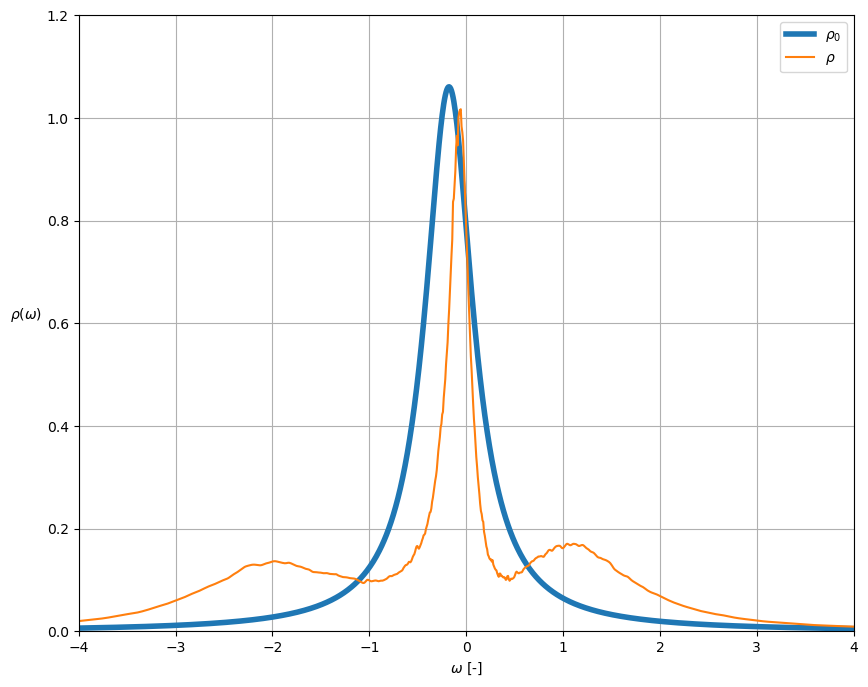

In [5]:
print(Sigma)
Ed=-2#np.real(AvgSigmadat[500])#U/2
finalG=np.nan_to_num(1/(omega-AvgSigmadat-Ed+1j*Gamma))
fDOS=-np.imag(finalG)/np.pi
plt.figure(figsize=(10,8))
plt.xlim(min(omega), max(omega))
plt.gca().set_ylim(bottom=0,top=1.2)
plt.xlabel("$\\omega$ [-]")
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.plot(omega,Lorentzian(omega,Gamma,poles,Sigma,Ed)[0],linewidth=4,label='$\\rho_0$')
plt.plot(omega, fDOS,label='$\\rho$')
plt.legend()
plt.grid()
plt.savefig('DOS_AIM030ncU3Sigmascv1897v2.png')

In [5]:
FinSigmadat2=[omega,fDOS]

np.savetxt('DOS_AIM030ncU3Sigmascv1897v2',np.transpose(FinSigmadat2), fmt='%.18g', delimiter='\t', newline='\n')
text_file = open("DOS_AIM030ncU3Sigmascv1897v2", "r")
lines = text_file.read().split('\n')
print(lines[0])
for i in range(len(lines)-1):
    lines[i]=lines[i].split('\t')
    for j in range(2):
        lines[i][j]=float(lines[i][j])
print(lines)
text_file.close()

-4	0.0189278908278645921
[[-4.0, 0.018927890827864592], [-3.992, 0.019096932660450826], [-3.984, 0.019265923943808466], [-3.976, 0.019434219919553908], [-3.968, 0.019601170911261845], [-3.96, 0.019766129710687575], [-3.952, 0.01992850059091386], [-3.944, 0.020087841808471195], [-3.936, 0.020244004573940103], [-3.928, 0.02039725240688166], [-3.92, 0.02054829688872808], [-3.912, 0.020698228614181063], [-3.904, 0.020848381925455017], [-3.896, 0.02100019871072158], [-3.888, 0.021155134541507938], [-3.88, 0.021314601284425774], [-3.872, 0.021479897912020433], [-3.864, 0.021652076451573733], [-3.856, 0.02183173476821213], [-3.848, 0.0220187978427404], [-3.84, 0.02221239566496676], [-3.832, 0.02241093249415885], [-3.824, 0.022612369834660764], [-3.816, 0.022814650497417117], [-3.808, 0.02301612672830052], [-3.8, 0.023215861636205953], [-3.792, 0.023413744294416963], [-3.784, 0.023610437002036556], [-3.776, 0.02380719774899951], [-3.768, 0.024005596062633257], [-3.76, 0.024207131532155646], [-